In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

# Deep Mixture Cure Model
# Contents
<a href='#LoadingLibraries'>1. Load all neccessary libraries</a><br/>
<a href='#EDA'>2. Explanatory Data Analysis</a><br/>
<a href='#ChooseFeatures'>3. Choose Features from Earlier Section or External Files</a><br/>
<a href='#ImputeWinsorizeStandardize'>4. Imputation, Winsorization, Standardization</a><br/>
<a href='#TrainTestModels'>5. Train & Test the Models</a><br/>
<a href='#FeatureAnalysis'>6. Analyze Model Features Importance and their Correlation</a><br/>
<a href='#ScoreMapping'>7. Build Score Mapping Functions</a><br/>
<a href='#CreateModelPickle'>8. Create Deployable Pickle File</a><br/>
<a href='#ModelComparison'>9. Compare Model Scores against each other</a><br/>
<a href='#AnalyzeFilter'>10. Analyze the impact of various filters on training data</a><br/>
<a href='#FeatureSelectionGAXGBoost'>11. Feature Selection via Genetic Algorithm - xgboost</a><br/>
<a href='#FeatureSelectionGAXLogReg'>12. Feature Selection via Genetic Algorithm - logreg </a><br/>

# Load all neccessary libraries and data<a id='LoadingLibraries'></a>

In [3]:
import pandas as pd
import numpy as np
import lifelines
from lifelines.utils import to_long_format

# Explanatory Analysis of Data<a id='EDA'></a>

In [4]:
loan_m = pd.read_csv('../mortgage/mortgage.csv')
loan_m['loan_time'] = loan_m.time - loan_m.orig_time
loan_m['label'] = [l if l == 1 else 0 for l in loan_m['status_time'] ]
loan_m['payoff_label'] = loan_m['payoff_time']

100
60


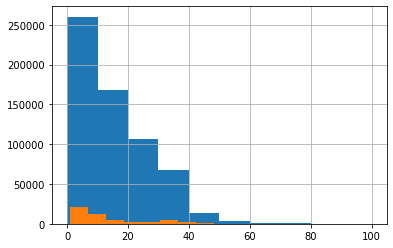

In [5]:
loan_m['loan_time'].hist()
print(loan_m['loan_time'].max())

loan_m.groupby('id').count().time.hist()
print(loan_m.groupby('id').count().time.max())  

#the max Y_x we could have, we have data until month 100, but Y_max 72, predit the survival in next 6 years at monthly rate.

In [6]:
cox_var = [var for var in loan_m.columns if not var in ['time', 'orig_time', 'first_time', 'mat_time',
'payoff_time', 'status_time', 'loan_time','label', 'default_time', 'payoff_label']]
print(cox_var)
orig_var = [ 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
varying_co = ['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time']

['id', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']


In [7]:
# prepare data for cox_regression without varying data
data_cox = loan_m[orig_var + ['id']]
data_cox = data_cox.groupby('id').median()
duration = loan_m.groupby('id').agg({'time':'count', 'status_time': 'max'}).reset_index()
duration.columns = ['id', 'duration', 'label']
data_cox = pd.merge(data_cox, duration, on = 'id', how = 'left')
data_cox['label'] = [1 if l == 1 else 0 for l in data_cox['label'] ]

<AxesSubplot:xlabel='timeline'>

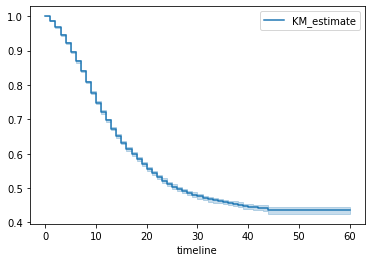

In [8]:
# kaplan cureve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data_cox["duration"]
E = data_cox["label"]

kmf.fit(T, event_observed=E)
kmf.plot()

In [9]:
from data_preprocess import *
feature_list = varying_co

In [10]:
data_process = preprocess_data(data_original =loan_m[loan_m.id < 20001], feature_list = feature_list,)

In [11]:
DATA, MASK, data_mi, pat_info = data_process.preprocess()

In [12]:
DATA[0].shape

(20000, 51, 7)

# RNN + FNN

In [63]:
# first neural network with keras tutorial
import tensorflow as tf
from tensorflow import keras as keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from datetime import datetime
from utils_layer import *

In [64]:
n_timesteps =  DATA[0].shape[1]
print(n_timesteps)

l_RNN = RNN_layer(n_timesteps = n_timesteps, n_features = 7, rnn_units = n_timesteps, n_layer_rnn = 2)
IN_ = tf.keras.Input(shape=(n_timesteps, 7))
x = Sequential(l_RNN)(IN_)
x = attention()(x)

51


In [65]:
FNN = Sequential(FNN_layer(128, n_layer_dense = 2, activation_fn_dense = None, 
drop = True, r_drop = 0.4))
x_1 = FNN(x)
x_2 = FNN(x)
outputs_1 = Dense(1, activation='sigmoid', trainable=True)(x_1)
outputs_2 = Dense(n_timesteps, activation='softmax', trainable=True)(x_2)

# build path to get sequence output and pi
M = keras.Model(inputs = IN_, outputs = [outputs_1, outputs_2])

In [66]:
M.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 51, 7)]      0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 51, 51)       33048       input_2[0][0]                    
__________________________________________________________________________________________________
attention_1 (attention)         (None, 51)           102         sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 72)           3744        attention_1[0][0]                
                                                                 attention_1[0][0]     

In [123]:
#compute loss
#log_likelihood
def Prob_Surv(batch_index, data, mask, OUT_h_i, RNN_net, 
 _EPSILON = 1e-08):
    (mask_1, mask_2, mask_3) = mask #MASK[0]
    
    mask_1 = tf.constant(mask_1[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_2 = tf.constant(mask_2[batch_index], shape = OUT_h_i.shape, dtype = 'float32')
    mask_3 = tf.constant(mask_3[batch_index], shape = OUT_h_i.shape, dtype = 'float32')

    if RNN_net == False:
        h_i = tf.clip_by_value(tf.reshape(tf.math.multiply(OUT_h_i, mask_1), mask_1.shape, name='h_i'), 0, 1)
        W_t = tf.reshape(tf.math.reduce_sum(h_i, axis=1, name='W_t'), (len(batch_index), 1))
        S_t = tf.clip_by_value(1 - W_t, _EPSILON, 1 - _EPSILON)
        p_il = tf.clip_by_value(tf.reshape(tf.reduce_sum(tf.reshape(tf.math.multiply(OUT_h_i, mask_2), mask_2.shape), axis = 1), (len(batch_index), 1)), _EPSILON, 1 - _EPSILON)#probbilbity at last measurement time f(t)
        return p_il, S_t

    else:
        h_i = tf.reshape(tf.math.multiply(OUT_h_i, mask_1), mask_1.shape, name='h_i')
        S_t = tf.reshape(tf.math.reduce_prod(1- h_i, axis=1, keepdims=False, name='S_i'),
        (len(batch_index), 1))

        h_last = tf.reduce_sum(tf.reshape(tf.math.multiply(OUT_h_i, mask_2), mask_2.shape), axis = 1) 
        # shape (batch_size, 1) unwanted points == 0
        mul_h = tf.math.reduce_prod(1- tf.math.multiply(OUT_h_i, mask_3, mask_3.shape,), axis=1)  # (50, 1)
        p_il = tf.reshape(tf.math.multiply(h_last, mul_h), (len(batch_index), 1))

        return p_il, S_t

def loss_likelihood(p_i, Prob, S_t, 
censoring_status, payoff_status, alpha = 1):   # censoring case == 0
    #weigths_censored   =  
    #weigths_uncensored = 
    
    # censored data
    l_censored = tf.math.add(tf.math.subtract(1, p_i), tf.math.multiply(p_i, S_t))
    l_censored = l_censored[censoring_status == 0]
    l_censored = tf.reduce_sum(
        tf.math.log(l_censored)
        )
        
    # uncensored data, true event time z
    l_uncensored = tf.math.multiply(p_i, Prob)
    l_uncensored = l_uncensored[censoring_status == 1]
    l_uncensored = tf.reduce_sum(
        tf.math.log(l_uncensored)
        )

    l_mixture = l_censored + l_uncensored
    # punishment of t>z
    l_uncensored_2 = tf.reduce_sum(
        tf.math.log((1-S_t)[censoring_status == 1])
        )
    
    l_censored_2 = tf.reduce_sum(
        tf.math.log((S_t)[censoring_status == 0])
        )

    l_c = l_uncensored_2 + l_censored_2 
    return -(alpha*l_mixture + (1-alpha)*l_c) 

#def ranking_loss():


In [31]:
# LOSS-FUNCTION 2 -- Ranking loss
def loss_Ranking(self): # input 
    sigma1 = tf.constant(0.1, dtype=tf.float32)

    eta = []
    for e in range(self.num_Event):
        one_vector = tf.ones_like(self.t, dtype=tf.float32)
        I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
        I_2 = tf.linalg.tensor_diag(tf.squeeze(I_2))
        tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

        R = tf.matmul(tmp_e, tf.transpose(a=self.fc_mask3)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

        diag_R = tf.reshape(tf.linalg.tensor_diag_part(R), [-1, 1])
        R = tf.matmul(one_vector, tf.transpose(a=diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
        R = tf.transpose(a=R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

        T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(a=self.t)) - tf.matmul(self.t, tf.transpose(a=one_vector))))
        # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

        T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

        tmp_eta = tf.reduce_mean(input_tensor=T * tf.exp(-R/sigma1), axis=1, keepdims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(input_tensor=tf.reshape(eta, [-1, self.num_Event]), axis=1, keepdims=True)

        self.LOSS_2 = tf.reduce_sum(input_tensor=eta) #sum over num_Events

IndentationError: unexpected indent (<ipython-input-31-6a849f51cdb9>, line 26)

In [122]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [124]:
def isNaN(x):
    return x != x

def train_step(batch_index, input, censoring_status, payoff_status):
    with tf.GradientTape() as tape:
        # make a prediction using the model and then calculate the
        # loss

        OUT_p_i_, OUT_h_i_ = M(inputs = input)  #output shape (batch_size, 1)
        p_il, S_t = Prob_Surv(batch_index, input, MASK[0], OUT_h_i_, RNN_net= False)
        loss_1 = loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status, alpha=0.5)
        
        #loss = tf.math.sqrt(abs(loss_1))*0.3 + loss_2*0.7
    # moniter susceptible ratio for default cases:
    try:
        acc = tf.keras.metrics.AUC(int(len(censoring_status)/2))
        acc.update_state(censoring_status[censoring_status + payoff_status == 1], OUT_p_i_[censoring_status + payoff_status == 1])
    except: 
        pass
    
    if isNaN(loss_1):
        sys.exit()
    
    gradients = tape.gradient(loss_1, M.trainable_variables)
    optimizer.apply_gradients(zip(gradients, M.trainable_variables))

    return acc.result().numpy(), loss_1.numpy()

num_epochs = 50
train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for i in range(1200):
        batch_index = range(i*15, i*15 + 15)
        input = DATA[0][batch_index]
        censoring_status = DATA[2][batch_index]
        payoff_status    = DATA[3][batch_index]

        score, loss,  = train_step(batch_index, input, censoring_status, payoff_status)

        epoch_loss_avg.update_state(loss)
        train_accuracy_results.append(score)
        train_loss_results.append(epoch_loss_avg.result())
        
        if i % 300 == 0:
            print("it {:03d}: Loss: {:.3f}, AUC: {:.3%}".format(i, epoch_loss_avg.result(), tf.math.reduce_mean(train_accuracy_results[-300:])))
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
     epoch_loss_avg.result(),
     tf.math.reduce_mean(train_accuracy_results[-15000:])))
    print('===================================')


In [126]:
pd.DataFrame(train_loss_results).to_csv('longhit_loss.csv')
pd.DataFrame(train_accuracy_results).to_csv('longhit_accuracy.csv')

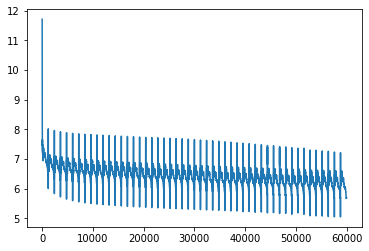

In [127]:
import matplotlib.pyplot as plt
plt.plot([i.numpy() for i in train_loss_results])

In [168]:
batch_index = range(-5000, 0)
input = DATA[0][batch_index]
censoring_status = DATA[2][batch_index]
payoff_status    = DATA[3][batch_index]
OUT_p_i_, OUT_h_i_ = M(inputs = DATA[0][batch_index])
p_il, S_t = Prob_Surv(batch_index, DATA[0], MASK[0], OUT_h_i_, RNN_net = False)
loss_likelihood(OUT_p_i_, p_il, S_t, censoring_status, payoff_status, alpha = 0.6)

<tf.Tensor: shape=(), dtype=float32, numpy=1595.4937>

In [169]:
from lifelines.utils import concordance_index

#C_index
names = batch_index
events = pat_info[:, 3][batch_index]
for i in [12, 24, 36, 48]:
    preds = tf.math.argmax(OUT_h_i_[:, :i], axis = 1).numpy()
    print(f'Concordance index: {concordance_index(events, preds)}')

Concordance index: 0.6016379353925484
Concordance index: 0.7162446054028454
Concordance index: 0.9342501044330151
Concordance index: 0.9369379657912031


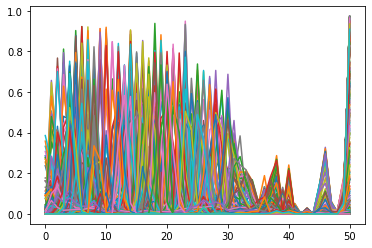

In [159]:
for i in range(len(OUT_h_i_)):
    plt.plot(range(n_timesteps), OUT_h_i_[i,:])

In [170]:
acc   = tf.keras.metrics.AUC(int(len(censoring_status)/2))
acc.update_state(censoring_status[censoring_status + payoff_status == 1], 
        OUT_p_i_[censoring_status + payoff_status == 1]
        )
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7006181>

2.0
[1.]


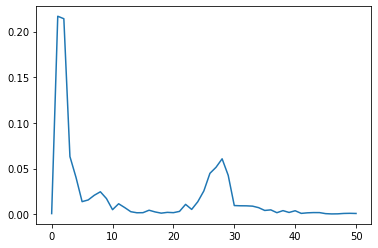

In [172]:
id = 1
plt.plot(range(n_timesteps), OUT_h_i_[id,:])
print(pat_info[:, 3][id])
print(censoring_status[id])